In [1]:
from river.datasets.synth import FriedmanDrift
from river.preprocessing import MinMaxScaler
from river.metrics import MAE
from river.utils import Rolling
from river.tree import HoeffdingTreeRegressor
from deep_river.regression import Regressor
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

In [2]:
n_samples = 12500
change_points = (5000, 7500)
friedman = FriedmanDrift(drift_type="gra", position=change_points)


def test_train_eval(model, stream, update_interval=100):
    results = []
    steps = []
    step = 0
    metric = Rolling(MAE(), window_size=400)
    scaler = MinMaxScaler()
    for x, y in tqdm(list(stream)):
        scaler.learn_one(x)
        x = scaler.transform_one(x)
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        metric.update(y, y_pred)
        step += 1
        if step % update_interval == 0:
            results.append(metric.get())
            steps.append(step)
    return steps, results

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden = nn.Linear(n_features, 20)
        self.logit = nn.Linear(20, 1)

    def forward(self, x):
        h = self.hidden(x)
        h = torch.relu(h)
        return self.logit(h)


mlp = Regressor(
    SimpleMLP,
    loss_fn="l1",
    optimizer_fn="adam",
    lr=0.005,
    seed=42,
)
steps, results_mlp = test_train_eval(mlp, friedman.take(n_samples))

  0%|                                                                                                                                                                                                                    | 0/12500 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                          | 1/12500 [00:01<3:32:01,  1.02s/it]

  1%|██▌                                                                                                                                                                                                      | 163/12500 [00:01<01:01, 200.21it/s]

  3%|█████▏                                                                                                                                                                                                   | 319/12500 [00:01<00:30, 403.17it/s]

  4%|███████▋                                                                                                                                                                                                 | 480/12500 [00:01<00:19, 615.03it/s]

  5%|██████████▍                                                                                                                                                                                              | 648/12500 [00:01<00:14, 828.22it/s]

  6%|████████████▉                                                                                                                                                                                           | 811/12500 [00:01<00:11, 1006.74it/s]

  8%|███████████████▋                                                                                                                                                                                        | 978/12500 [00:01<00:09, 1166.75it/s]

  9%|██████████████████▏                                                                                                                                                                                    | 1144/12500 [00:01<00:08, 1292.41it/s]

 10%|████████████████████▊                                                                                                                                                                                  | 1311/12500 [00:01<00:08, 1391.71it/s]

 12%|███████████████████████▍                                                                                                                                                                               | 1474/12500 [00:01<00:07, 1437.49it/s]

 13%|██████████████████████████                                                                                                                                                                             | 1634/12500 [00:02<00:07, 1482.84it/s]

 14%|████████████████████████████▋                                                                                                                                                                          | 1800/12500 [00:02<00:06, 1531.37it/s]

 16%|███████████████████████████████▏                                                                                                                                                                       | 1962/12500 [00:02<00:06, 1549.08it/s]

 17%|█████████████████████████████████▊                                                                                                                                                                     | 2126/12500 [00:02<00:06, 1575.13it/s]

 18%|████████████████████████████████████▍                                                                                                                                                                  | 2292/12500 [00:02<00:06, 1599.06it/s]

 20%|███████████████████████████████████████                                                                                                                                                                | 2455/12500 [00:02<00:06, 1597.32it/s]

 21%|█████████████████████████████████████████▊                                                                                                                                                             | 2623/12500 [00:02<00:06, 1621.39it/s]

 22%|████████████████████████████████████████████▍                                                                                                                                                          | 2790/12500 [00:02<00:05, 1635.57it/s]

 24%|███████████████████████████████████████████████                                                                                                                                                        | 2955/12500 [00:02<00:05, 1634.53it/s]

 25%|█████████████████████████████████████████████████▋                                                                                                                                                     | 3122/12500 [00:02<00:05, 1642.04it/s]

 26%|████████████████████████████████████████████████████▎                                                                                                                                                  | 3289/12500 [00:03<00:05, 1648.02it/s]

 28%|███████████████████████████████████████████████████████                                                                                                                                                | 3460/12500 [00:03<00:05, 1660.62it/s]

 29%|█████████████████████████████████████████████████████████▋                                                                                                                                             | 3627/12500 [00:03<00:05, 1619.08it/s]

 30%|████████████████████████████████████████████████████████████▎                                                                                                                                          | 3790/12500 [00:03<00:05, 1601.64it/s]

 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                        | 3953/12500 [00:03<00:05, 1607.78it/s]

 33%|█████████████████████████████████████████████████████████████████▍                                                                                                                                     | 4114/12500 [00:03<00:05, 1603.16it/s]

 34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 4284/12500 [00:03<00:05, 1629.13it/s]

 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                | 4452/12500 [00:03<00:04, 1644.20it/s]

 37%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4617/12500 [00:03<00:04, 1621.89it/s]

 38%|████████████████████████████████████████████████████████████████████████████                                                                                                                           | 4780/12500 [00:03<00:04, 1602.88it/s]

 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 4946/12500 [00:04<00:04, 1617.06it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 5108/12500 [00:04<00:04, 1606.54it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 5270/12500 [00:04<00:04, 1609.68it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 5432/12500 [00:04<00:04, 1586.19it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 5600/12500 [00:04<00:04, 1611.84it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 5762/12500 [00:04<00:04, 1599.17it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 5932/12500 [00:04<00:04, 1628.63it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 6103/12500 [00:04<00:03, 1651.32it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 6269/12500 [00:04<00:03, 1627.29it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 6432/12500 [00:04<00:03, 1627.94it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 6600/12500 [00:05<00:03, 1641.64it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 6767/12500 [00:05<00:03, 1649.99it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 6933/12500 [00:05<00:03, 1640.88it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 7098/12500 [00:05<00:03, 1614.21it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 7268/12500 [00:05<00:03, 1637.43it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 7432/12500 [00:05<00:03, 1632.45it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 7596/12500 [00:05<00:03, 1628.53it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 7767/12500 [00:05<00:02, 1651.19it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 7933/12500 [00:05<00:02, 1636.53it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 8097/12500 [00:05<00:02, 1634.83it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 8261/12500 [00:06<00:02, 1590.31it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 8421/12500 [00:06<00:02, 1567.33it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 8578/12500 [00:06<00:02, 1565.05it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 8744/12500 [00:06<00:02, 1590.91it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 8908/12500 [00:06<00:02, 1603.73it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 9072/12500 [00:06<00:02, 1614.30it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 9241/12500 [00:06<00:01, 1635.95it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 9410/12500 [00:06<00:01, 1650.03it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 9576/12500 [00:06<00:01, 1631.38it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 9740/12500 [00:07<00:01, 1553.36it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 9902/12500 [00:07<00:01, 1570.45it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 10060/12500 [00:07<00:01, 1562.11it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 10217/12500 [00:07<00:01, 1523.48it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 10380/12500 [00:07<00:01, 1553.12it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 10536/12500 [00:07<00:01, 1554.98it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 10703/12500 [00:07<00:01, 1586.49it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 10876/12500 [00:07<00:00, 1627.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 11045/12500 [00:07<00:00, 1644.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 11210/12500 [00:07<00:00, 1581.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 11369/12500 [00:08<00:00, 1565.69it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 11528/12500 [00:08<00:00, 1571.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 11689/12500 [00:08<00:00, 1580.15it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 11854/12500 [00:08<00:00, 1600.61it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 12020/12500 [00:08<00:00, 1616.11it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 12182/12500 [00:08<00:00, 1611.00it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 12346/12500 [00:08<00:00, 1617.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:08<00:00, 1427.15it/s]

In [4]:
tree = HoeffdingTreeRegressor()
steps, results_tree = test_train_eval(tree, friedman.take(n_samples))

  0%|                                                                                                                                                                                                                    | 0/12500 [00:00<?, ?it/s]

  1%|█▎                                                                                                                                                                                                        | 85/12500 [00:00<00:16, 739.83it/s]

  8%|███████████████▊                                                                                                                                                                                        | 987/12500 [00:00<00:02, 5323.96it/s]

 18%|███████████████████████████████████▍                                                                                                                                                                   | 2229/12500 [00:00<00:01, 8456.84it/s]

 28%|██████████████████████████████████████████████████████▊                                                                                                                                                | 3444/12500 [00:00<00:00, 9885.26it/s]

 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 4608/12500 [00:00<00:00, 10507.51it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 5799/12500 [00:00<00:00, 10978.41it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 6906/12500 [00:00<00:00, 10864.24it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 8262/12500 [00:00<00:00, 11710.11it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 9439/12500 [00:00<00:00, 11521.05it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 10596/12500 [00:01<00:00, 11463.29it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 11746/12500 [00:01<00:00, 10927.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 10286.64it/s]

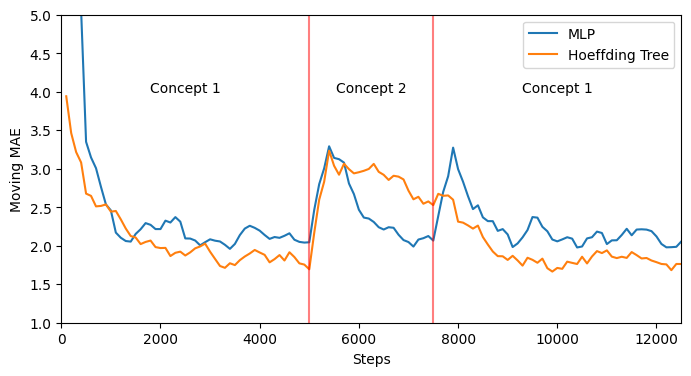

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(steps, results_mlp, label="MLP")
ax.plot(steps, results_tree, label="Hoeffding Tree")
for change_point in change_points:
    ax.axvline(change_point, color="red", alpha=0.5)
ax.set_xlim(0, n_samples)
ax.set_ylim(1, 5)
plt.text(
    int(change_points[0] / 2), 4, "Concept 1", horizontalalignment="center"
)
plt.text(
    int(change_points[0] + (change_points[1] - change_points[0]) / 2),
    4,
    "Concept 2",
    horizontalalignment="center",
)
plt.text(
    int(change_points[1] + (n_samples - change_points[1]) / 2),
    4,
    "Concept 1",
    horizontalalignment="center",
)

ax.set_xlabel("Steps")
ax.set_ylabel("Moving MAE")
ax.legend()